In [1]:
print("start")
import torch
import csv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
from torchvision import datasets, transforms
import sys
import random
sys.path.append('../../')
from src.models.frequency.sketch_algorithms import SketchQueryalgorithms
from src.datasets.zipf import get_zipf_probs, get_dataset_samples, ZipfOnlineDatasetLoader
#sys.path.append('../../')
#from benchmark_wd import bestparameters_CM_CS

start


This notebook reads the numpy files genereted by bestparameters_BF.py, where we can find different combinations of alpha and beta, and for each combination different d and w are used depending on the sketch size. Each file has a different sketch size.
This notebook shows different plots taking the best parameters for each alpha and beta.

## Functions

#### Compute BF with different beta and alpha to find the best w and d

In [2]:
## Function bestparameters_CM_CS

#### Compute the mean of the runs and find the optimum w and d for each alpha and beta

In [3]:
def mean_runs(list_w,list_d,space_alpha,space_beta,runs,num_samples,n_dims,err_bf):
    # Compute the Mean of the runs
    MSE_error_bf = np.mean(err_bf,0)

    sd_error_bf = np.std(err_bf,0)

    ## Find the w and d that has an smaller error, for each beta and alpha
    #print(MSE_error_cm)
    # Sort the vector (first position: beta, second: alpha, third: w or d) and take indexes to know which w and d are
    df_bf = pd.DataFrame(columns =['alpha', 'beta','d','w','MSE'])
    for beta in range(len(space_beta)):
        for alpha in range(len(space_alpha)):
            idx_bf = np.argsort(MSE_error_bf[beta][alpha])[0]
            df_bf = df_bf.append({'alpha': space_alpha[alpha].item() , 'beta': space_beta[beta].item(), 'd': list_d[idx_bf], 'w':list_w[idx_bf],'MSE':MSE_error_bf[beta][alpha][idx_bf]},ignore_index = True)


    #print(df_cm)
    #print(df_cs)
    return df_bf


#### Compute the mean and sd of the optimal w and d of each run for a particular alpha and beta

In [4]:
def compute_mean_sd(list_w,list_d,space_alpha,space_beta,runs,num_samples,n_dims,err_bf):
    # Save in a dataframe the numpy array: Save the optimal d and w for each beta and alpha and for each run
    # Sort the vector (first position: beta, second: alpha, third: w or d) and take indexes to know which w and d are
    df_bf = pd.DataFrame(columns =['run','alpha', 'beta','d','w','MSE'])
    for run in range(runs):
        for beta in range(len(space_beta)):
            for alpha in range(len(space_alpha)):
                idx_bf = np.argsort(err_bf[run][beta][alpha])[0]
                df_bf = df_bf.append({'alpha': space_alpha[alpha].item() , 'beta': space_beta[beta].item(), 'd': list_d[idx_bf], 'w':list_w[idx_bf],'MSE':err_bf[run][beta][alpha][idx_bf],'run':run},ignore_index = True)


    #print(df_cm)
    #print(df_cs)
    ##### CS 
    # Compute mean and sd of the runs for each alpha and beta
    mean = df_bf.groupby(['alpha','beta']).mean().reset_index()
    sd = df_bf.groupby(['alpha','beta']).std().reset_index()

    # Rename columns
    df_bf_mean = mean.rename(columns = {'d':'mean_d', 'w':'mean_w','MSE':'Mean_MSE'})

    # Create new columns
    df_bf_mean['sd_d'] = sd['d']
    df_bf_mean['sd_w'] = sd['w']
    df_bf_mean['sd_MSE'] = sd['MSE']

    ## Save df_cm and df_cs
    #df_cm_mean.to_csv('../../benchmark_wd/optimum_w_d_CM.csv') 
    #df_cs_mean.to_csv('../../benchmark_wd/optimum_w_d_CS.csv')
    return df_bf_mean,df_bf


In [5]:
## Save df_cm and df_cs
#df_cm_mean.to_csv('../../benchmark_wd/optimum_w_d_CM.csv') 
#df_cs_mean.to_csv('../../benchmark_wd/optimum_w_d_CS.csv')

In [6]:
# Read df_cm and df_cs
#df_cm = pd.read_csv('../../benchmark_wd/optimum_w_d_CM.csv') 
#df_cs = pd.read_csv('../../benchmark_wd/optimum_w_d_CS.csv') 

#### Take the d and w that appear more times in the runs for a particular alpha and beta (optimum)

In [7]:
def compute_optimal(space_beta,space_alpha,df_bf,size):
    # Define optimum cm and cs
    optimum_bf = pd.DataFrame(columns =['alpha', 'beta','d','w','MSE','sd_MSE'])

    for beta in range(len(space_beta)):
        for alpha in range(len(space_alpha)):
            ## Count sketch
            df_BF = df_bf[(df_bf['alpha']==space_alpha[alpha].item()) & (df_bf['beta']==space_beta[beta].item())]
            (unique_w, counts_w) = np.unique(df_BF['w'], return_counts=True)
            idx_w = np.argsort(counts_w)[len(counts_w)-1]
            (unique_d, counts_d) = np.unique(df_BF['d'], return_counts=True)
            idx_d = np.argsort(counts_d)[len(counts_d)-1]
            optimum_bf = optimum_bf.append({'alpha': space_alpha[alpha].item() , 'beta': space_beta[beta].item(), 'd': unique_d[idx_d], 'w':unique_w[idx_w],'MSE':df_BF['MSE'].mean(),'sd_MSE':df_BF['MSE'].std()},ignore_index = True)


    # optimum_cm[(optimum_cm['alpha']==space_alpha[3].item()) & (optimum_cm['beta']==space_beta[3].item())]
    ## Save dataframes
    #optimum_bf.to_csv('../../results/benchmark_wd/optimum_w_d_BF_sketch_' + str(size) +'.csv') 



# Functions plots

#### Alpha vs MSE error, fixing the Beta to a number and taking the optimum w and d

In [8]:
def fix_Beta_opt_dw(df_bf_mean):
    # Each line is a particular beta
    fig = plt.figure(figsize=(10, 6))
    #plt.subplot(1, 2, 1)
    for v_beta in list(df_bf_mean['beta'].unique()):
        beta_i = df_bf_mean[df_bf_mean['beta']==v_beta]
        #plt.plot(beta_i['alpha'], beta_i['MSE'],label=str(v_beta))
        plt.errorbar(beta_i['alpha'], beta_i['Mean_MSE'], yerr = beta_i['sd_MSE'], fmt = '-o', 
                    markeredgewidth=1,label=str(v_beta))
        plt.xlabel("alpha")
        plt.ylabel("MSE loss")
        plt.title('MSE loss for different beta and alpha values',fontsize=14)
        plt.legend(title= 'Beta values',loc='center left', bbox_to_anchor=(1, 0.8))
    
    #plt.savefig('../../results/plots_CM_CS_BF/Bloomfilter_MSE_vs_alpha', bbox_inches='tight')
    plt.show()
    plt.close()

In [9]:
def fix_Beta_opt_dw_zoom(df_bf_mean):
    ## ZOOM 
    # Each line is a particular beta
    #fig = plt.figure(figsize=(10, 6))
    #plt.subplot(1, 2, 1)
    for v_beta in list(df_bf_mean['beta'].unique()):
        beta_i = df_bf_mean[df_bf_mean['beta']==v_beta]
        #plt.plot(beta_i['alpha'], beta_i['MSE'],label=str(v_beta))
        plt.errorbar(beta_i['alpha'], beta_i['Mean_MSE'], yerr = beta_i['sd_MSE'], fmt = '-o', 
                    ecolor = 'black',markeredgewidth=1,label=str(v_beta))
        plt.xlabel("alpha")
        plt.ylabel("MSE loss")
        plt.title('MSE loss for different beta and alpha values',fontsize=14)
        plt.ylim([0, 0.40])
        plt.xlim([1.4, 2.0])
        plt.legend(title= 'Beta values',loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()
    plt.close()

#### Beta vs MSE error, fixing the alpha to a number and taking the optimum w and d

In [10]:
def fix_Alpha_opt_dw(df_bf_mean):
    # Each line is a particular alpha
    #fig = plt.figure(figsize=(10, 6))
    #plt.subplot(1, 2, 1)
    for v_alpha in list(df_bf_mean['alpha'].unique()):
        alpha_i = df_bf_mean[df_bf_mean['alpha']==v_alpha]
        #plt.plot(alpha_i['beta'], alpha_i['MSE'],label=str(v_alpha))
        plt.errorbar(alpha_i['beta'], alpha_i['Mean_MSE'], yerr = alpha_i['sd_MSE'], fmt = '-o', 
                    ecolor = 'black',markeredgewidth=1,label=str(v_alpha))
        plt.xlabel("Beta")
        plt.ylabel("MSE loss")
        plt.title('MSE loss for different beta and alpha values',fontsize=14)
        plt.legend(title= 'Alpha values',loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()
    plt.close()

#### Separate plots in subplots

In [11]:
def fix_Beta_opt_dw_subplots_bf(df_bf_mean):
    # Each line is a particular beta
    fig = plt.figure(figsize=(14, 15))
    #plt.subplot(1, 5, 5)
    x_i = 1
    for v_beta in list(df_bf_mean['beta'].unique()):
        plt.subplot(4, 3, x_i)
        x_i += 1
        beta_i = df_bf_mean[df_bf_mean['beta']==v_beta]
        #plt.plot(beta_i['alpha'], beta_i['MSE'],label='CM')
        plt.errorbar(beta_i['alpha'], beta_i['Mean_MSE'], yerr = beta_i['sd_MSE'], fmt = '-o', 
                    color = 'orange',markeredgewidth=1,label='BF',elinewidth=1)
        plt.xlabel("alpha",fontsize=8)
        plt.ylabel("MSE loss",fontsize=8)
        plt.title("Beta:{}".format(round(v_beta,2)),fontsize=8)
        #plt.show()
        #plt.close()
        #plt.legend(title= 'Alpha values',loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
    plt.suptitle('MSE loss for different beta and alpha values (BF)',fontsize=14)
    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.9))
    plt.show()
    plt.close()

#### Alpha vs W (Find the optimum beta, w and d for each alpha)

In [12]:
def optimum_beta_d_w(df_bf_mean):
    ## Fix beta and select the minimum alpha
    df_bf_beta = df_bf_mean.sort_values("Mean_MSE").drop_duplicates(subset ="beta",keep = 'first')


    ## Fix alpha and select the minimum beta
    df_bf_alpha = df_bf_mean.sort_values("Mean_MSE").drop_duplicates(subset ="alpha",keep = 'first')
    return df_bf_alpha

In [13]:
def plots_optimum_beta_d_w(df_bf_mean):
    df_bf_alpha = optimum_beta_d_w(df_bf_mean)
    # Different alphas, with the best Beta,w and d
    fig = plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    #plt.plot(df_cm_alpha['alpha'], df_cm_alpha['w'],'bo')
    plt.errorbar(df_bf_alpha['alpha'], df_bf_alpha['mean_w'], yerr = df_bf_alpha['sd_w'], fmt = 'o', 
                color = 'orange',markeredgewidth=1,label='BF',elinewidth=1)
    plt.xlabel('alpha')
    plt.ylabel('w')
    plt.title('Different alphas, with the best Beta,w and d ',fontsize=14)
    plt.show()
    plt.close()

#### Alpha vs W (Fix Beta value and find the optimum w and d for each value)

In [14]:
def fix_Beta_optimum_d_w_difalphas(df_bf_mean):
    # Each line is a particular beta
    fig = plt.figure(figsize=(10, 8))
    #plt.subplot(1, 5, 5)
    x_i = 1
    l = list(df_bf_mean['beta'].unique())
    for v_beta in l[1:len(l)]:
        plt.subplot(2, 2, x_i)
        x_i += 1
        beta_i = df_bf_mean[df_bf_mean['beta']==v_beta]
        #plt.plot(beta_i['alpha'], beta_i['mean_w'],label='CS')
        plt.errorbar(beta_i['alpha'], beta_i['mean_w'], yerr = beta_i['sd_w'], fmt = '-o',color = 'orange', 
                    ecolor = 'orange',markeredgewidth=1,label='BF',elinewidth=1)
        #plt.plot(beta_j['alpha'], beta_j['mean_w'],label='CM')
        plt.xlabel("alpha",fontsize=8)
        plt.ylabel("w",fontsize=8)
        plt.title("Beta:{}".format(round(v_beta,2)),fontsize=8)
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
    plt.suptitle('w for different beta and alpha values (CS and CM)',fontsize=14)
    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.25)
    plt.legend(loc='center left', bbox_to_anchor=(1, 2.1)) #12.5
    #plt.savefig('../../results/plots_CM_CS_BF/Bloomfilter_w_vs_alpha', bbox_inches='tight')
    plt.show()
    plt.close()

# Sketch size 100 (50 samples)

#### Define parameters

In [15]:
# Fix sketch size (1000)
list_w = [1,2,4,5,10,20,25,50,100] 
list_d = [100,50,25,20,10,5,4,2,1] 
space_alpha = torch.linspace(0.0, 2.0, 20)
space_beta = torch.linspace(0, 1.0, 5)
runs = 10
num_samples = 10
n_dims = 1000 # Input dimention
err_cm = np.zeros([runs,len(space_beta),len(space_alpha),len(list_w)])
err_cs = np.zeros([runs,len(space_beta),len(space_alpha),len(list_w)])

In [16]:
## Compute Bloom filters with different beta and alpha to find the best w and d
#bestparameters_CM_CS.main(sketch_size=1000)

In [17]:
## Read data
err_bf = np.load('../../results/benchmark_wd/error_MSE_BF_Sketch100.npy')

In [18]:
err_bf.shape

(10, 5, 20, 9)

In [19]:
## compute mean and std of each run
df_bf_mean,df_bf = compute_mean_sd(list_w,list_d,space_alpha,space_beta,runs,num_samples,n_dims,err_bf)

In [20]:
## Compute the optimals d and w
# Search the d and w that are selected more times (in the different runs) and save the dataframes
#compute_optimal(space_beta,space_alpha,df_bf,100)

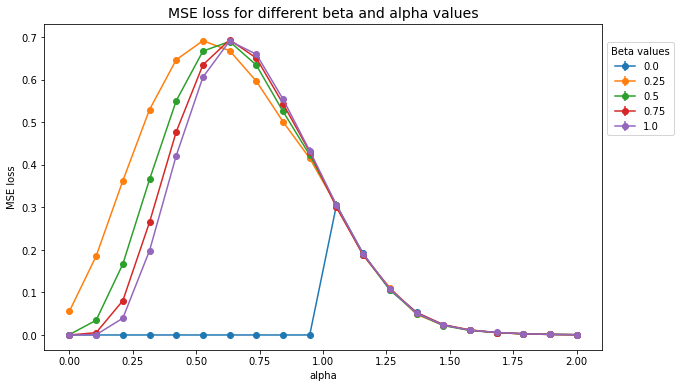

In [21]:
## Alpha vs MSE error, fixing the Beta to a number and taking the optimum w and d
fix_Beta_opt_dw(df_bf_mean)

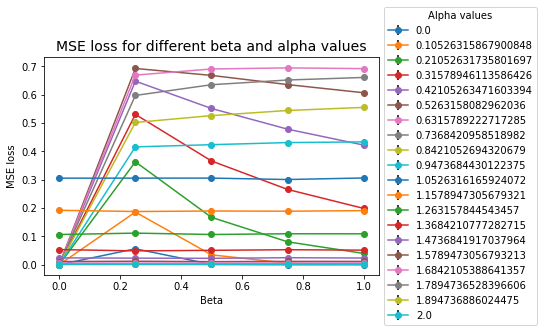

In [22]:
## Beta vs MSE error, fixing the alpha to a number and taking the optimum w and d
fix_Alpha_opt_dw(df_bf_mean)

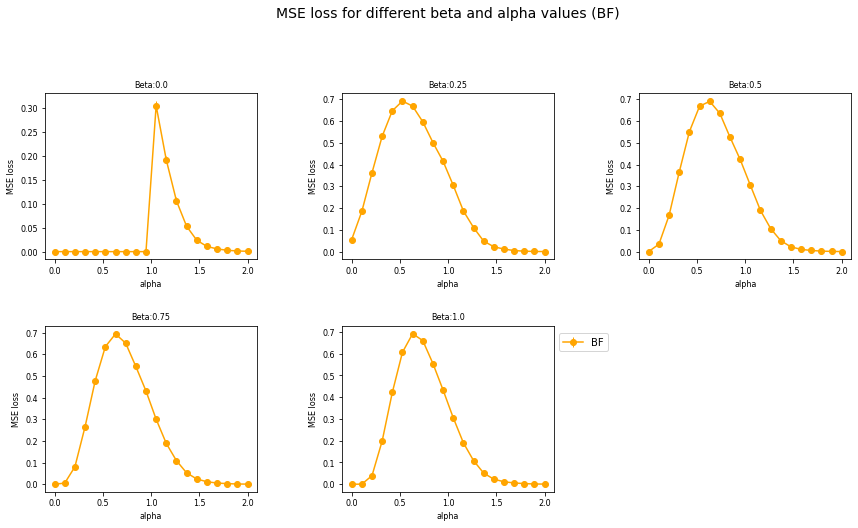

In [23]:
## Separate plots in subplots
fix_Beta_opt_dw_subplots_bf(df_bf_mean)

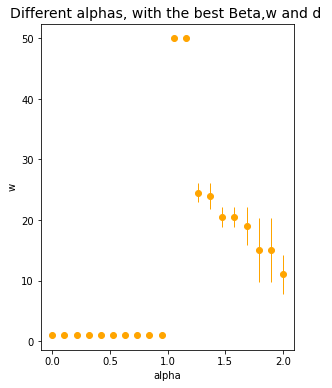

In [24]:
## Alpha vs W (Find the optimum beta, w and d for each alpha)
plots_optimum_beta_d_w(df_bf_mean)

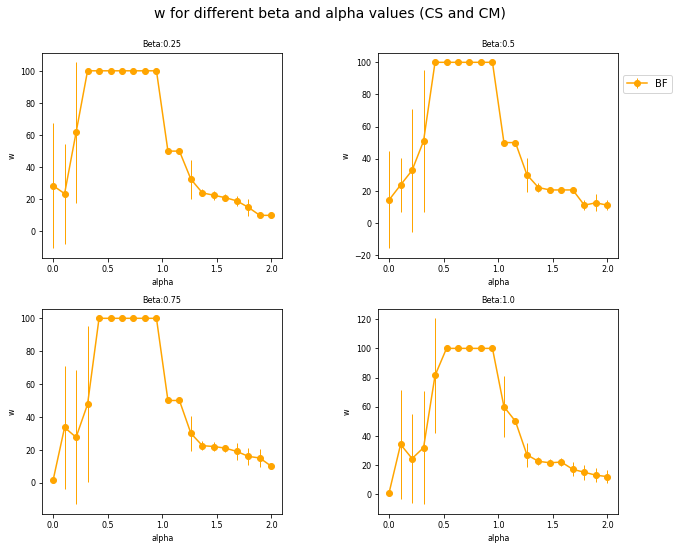

In [25]:
## Alpha vs W (Fix Beta value and find the optimum w and d for each value)
fix_Beta_optimum_d_w_difalphas(df_bf_mean)

# Sketch size 10 (50 samples)

#### Define parameters

In [26]:
# Fix sketch size (1000)
list_w = [1,2,5,10]
list_d = [10,5,2,1] 
space_alpha = torch.linspace(0.0, 2.0, 20)
space_beta = torch.linspace(0, 1.0, 5)
runs = 10
num_samples = 10
n_dims = 1000 # Input dimention
err_cm = np.zeros([runs,len(space_beta),len(space_alpha),len(list_w)])
err_cs = np.zeros([runs,len(space_beta),len(space_alpha),len(list_w)])

In [27]:
## Compute Bloom filters with different beta and alpha to find the best w and d
#bestparameters_CM_CS.main(sketch_size=1000)

In [28]:
## Read data
err_bf = np.load('../../results/benchmark_wd/error_MSE_BF_Sketch10.npy')

In [29]:
err_bf.shape

(10, 5, 20, 4)

In [30]:
## compute mean and std of each run
df_bf_mean,df_bf = compute_mean_sd(list_w,list_d,space_alpha,space_beta,runs,num_samples,n_dims,err_bf)

In [31]:
## Compute the optimals d and w
# Search the d and w that are selected more times (in the different runs) and save the dataframes
#compute_optimal(space_beta,space_alpha,df_bf,10)

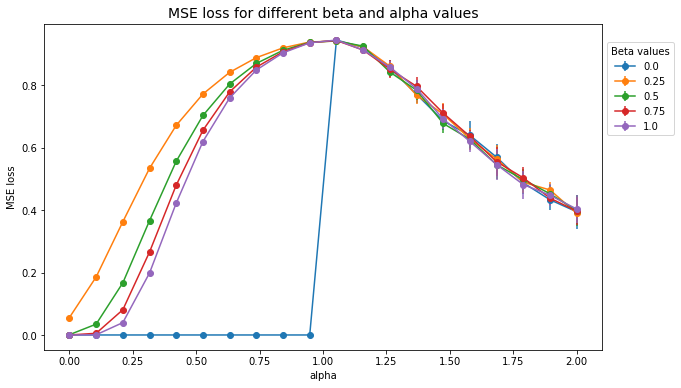

In [32]:
## Alpha vs MSE error, fixing the Beta to a number and taking the optimum w and d
fix_Beta_opt_dw(df_bf_mean)

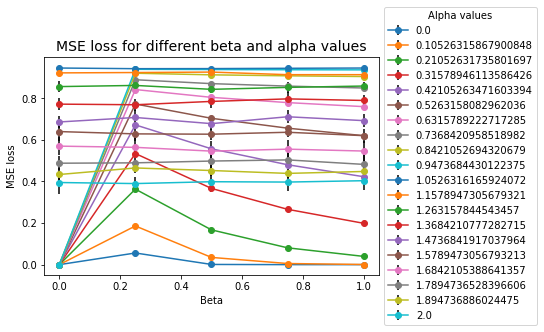

In [33]:
## Beta vs MSE error, fixing the alpha to a number and taking the optimum w and d
fix_Alpha_opt_dw(df_bf_mean)

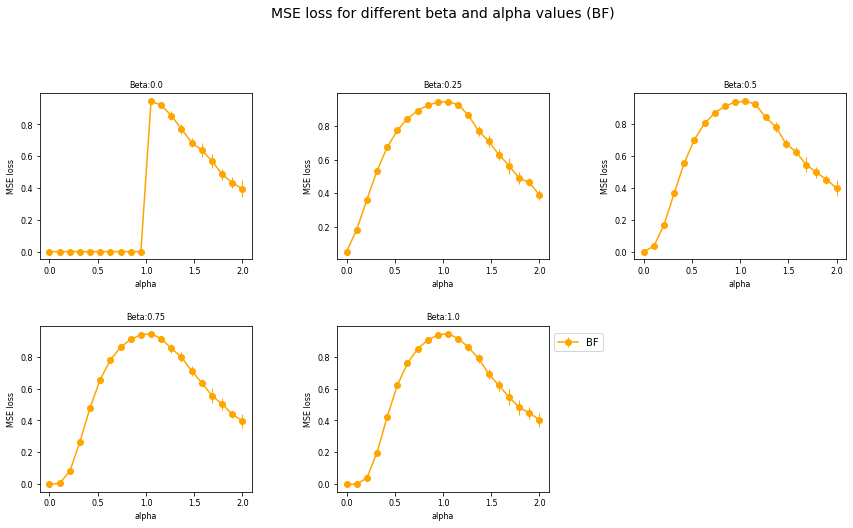

In [34]:
## Separate plots in subplots
fix_Beta_opt_dw_subplots_bf(df_bf_mean)

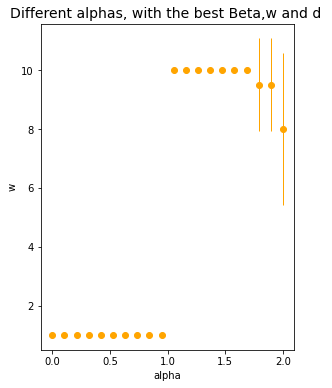

In [35]:
## Alpha vs W (Find the optimum beta, w and d for each alpha)
plots_optimum_beta_d_w(df_bf_mean)

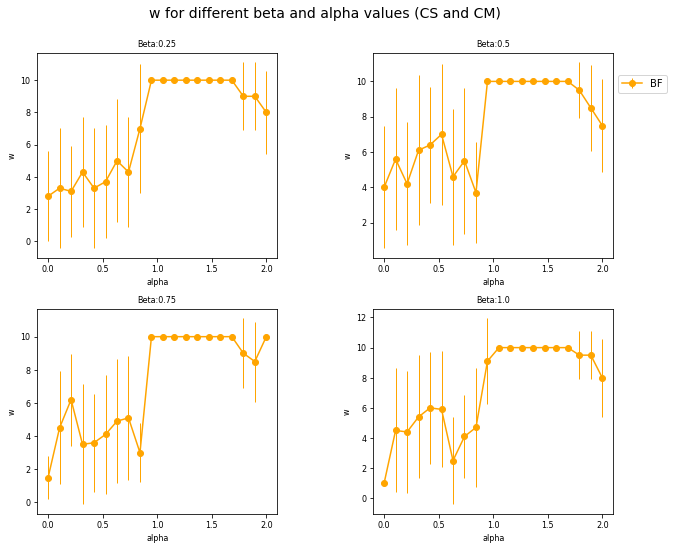

In [36]:
## Alpha vs W (Fix Beta value and find the optimum w and d for each value)
fix_Beta_optimum_d_w_difalphas(df_bf_mean)